In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../src/")
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from handcrafted_features import DocBasedFeatureExtractor, Doc2VecChunkVectorizer, CorpusBasedFeatureExtractor
from utils import get_doc_paths, read_labels

raw_docs_dir = "../data/raw_docs/"
labels_dir = "../data/labels/"

lang = "eng"
doc_paths = get_doc_paths(raw_docs_dir, lang)
sentences_per_chunk = 200
#d2vcv = Doc2VecChunkVectorizer(lang, sentences_per_chunk)
#d2vcv.fit_transform(doc_paths)

/home/annina/anaconda3/envs/nlp/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
doc_paths = os.listdir('/home/annina/scripts/great_unread_nlp/data/processed_sentences/eng') #####
doc_paths = ['../data/raw_docs/eng/' + path for path in doc_paths][:20]
print(doc_paths)

['../data/raw_docs/eng/Radcliffe_Ann_The-Italian_1797.txt', '../data/raw_docs/eng/Gissing_George_In-the-Year-of-Jubilee_1894.txt', '../data/raw_docs/eng/Collins_Wilkie_Armadale_1864.txt', '../data/raw_docs/eng/Conrad_Joseph_Lord-Jim_1899.txt', '../data/raw_docs/eng/Shelley_Mary_Perkin-Warbeck_1830.txt', '../data/raw_docs/eng/Stretton_Hesba_Jessicas-First-Prayer_1867.txt', '../data/raw_docs/eng/Doyle_Arthur-Conan_The-Adventure-of-the-Dancing-Men_1905.txt', '../data/raw_docs/eng/Trollope_Anthony_Barchester-Towers_1857.txt', '../data/raw_docs/eng/Carleton_William_Fardorougha-the-Miser_1839.txt', '../data/raw_docs/eng/Nesbit_Edith_The-Story-of-the-Treasure-Seekers_1899.txt', '../data/raw_docs/eng/Barrie_J-M_Tommy-and-Grizel_1900.txt', '../data/raw_docs/eng/Conrad_Joseph_Heart-of-Darkness_1899.txt', '../data/raw_docs/eng/Moore_George_Esther-Waters_1894.txt', '../data/raw_docs/eng/Stevenson_Robert-Louis_The-Body-Snatcher_1884.txt', '../data/raw_docs/eng/Roche_Regina-Maria_The-Children-of-the

In [3]:
all_chunk_based_features = []
all_book_based_features = []
all_average_sbert_sentence_embeddings = []
all_doc2vec_chunk_embeddings = []
for doc_path in tqdm(doc_paths):
    print(doc_path)
    fe = DocBasedFeatureExtractor(lang, doc_path, sentences_per_chunk)
    chunk_based_features, book_based_features, average_sbert_sentence_embeddings, doc2vec_chunk_embeddings = fe.get_all_features()
    all_chunk_based_features.extend(chunk_based_features)
    all_book_based_features.append(book_based_features)
    all_average_sbert_sentence_embeddings.append(average_sbert_sentence_embeddings)
    all_doc2vec_chunk_embeddings.append(doc2vec_chunk_embeddings)

  0%|          | 0/20 [00:00<?, ?it/s]

../data/raw_docs/eng/Radcliffe_Ann_The-Italian_1797.txt


  5%|▌         | 1/20 [00:04<01:23,  4.38s/it]

../data/raw_docs/eng/Gissing_George_In-the-Year-of-Jubilee_1894.txt


 10%|█         | 2/20 [00:08<01:19,  4.44s/it]

../data/raw_docs/eng/Collins_Wilkie_Armadale_1864.txt


 15%|█▌        | 3/20 [00:15<01:28,  5.21s/it]

../data/raw_docs/eng/Conrad_Joseph_Lord-Jim_1899.txt


 20%|██        | 4/20 [00:19<01:15,  4.70s/it]

../data/raw_docs/eng/Shelley_Mary_Perkin-Warbeck_1830.txt


 25%|██▌       | 5/20 [00:24<01:09,  4.65s/it]

../data/raw_docs/eng/Stretton_Hesba_Jessicas-First-Prayer_1867.txt


 30%|███       | 6/20 [00:24<00:49,  3.54s/it]

../data/raw_docs/eng/Doyle_Arthur-Conan_The-Adventure-of-the-Dancing-Men_1905.txt


 35%|███▌      | 7/20 [00:25<00:34,  2.63s/it]

../data/raw_docs/eng/Trollope_Anthony_Barchester-Towers_1857.txt


 40%|████      | 8/20 [00:30<00:38,  3.22s/it]

../data/raw_docs/eng/Carleton_William_Fardorougha-the-Miser_1839.txt


 45%|████▌     | 9/20 [00:33<00:34,  3.14s/it]

../data/raw_docs/eng/Nesbit_Edith_The-Story-of-the-Treasure-Seekers_1899.txt


 50%|█████     | 10/20 [00:34<00:26,  2.61s/it]

../data/raw_docs/eng/Barrie_J-M_Tommy-and-Grizel_1900.txt


 55%|█████▌    | 11/20 [00:37<00:24,  2.74s/it]

../data/raw_docs/eng/Conrad_Joseph_Heart-of-Darkness_1899.txt


 60%|██████    | 12/20 [00:38<00:19,  2.38s/it]

../data/raw_docs/eng/Moore_George_Esther-Waters_1894.txt


 65%|██████▌   | 13/20 [00:42<00:20,  2.86s/it]

../data/raw_docs/eng/Stevenson_Robert-Louis_The-Body-Snatcher_1884.txt


 70%|███████   | 14/20 [00:43<00:13,  2.18s/it]

../data/raw_docs/eng/Roche_Regina-Maria_The-Children-of-the-Abbey_1796.txt


 75%|███████▌  | 15/20 [00:50<00:17,  3.56s/it]

../data/raw_docs/eng/Conrad_Joseph_Chance_1912.txt


 80%|████████  | 16/20 [00:54<00:14,  3.69s/it]

../data/raw_docs/eng/Holcroft_Thomas_The-Adventures-of-Hugh-Trevor_1794.txt


 85%|████████▌ | 17/20 [01:00<00:12,  4.30s/it]

../data/raw_docs/eng/Somerville-Ross_Edith-Martin_An-Irish-Cousin_1889.txt


 90%|█████████ | 18/20 [01:02<00:07,  3.86s/it]

../data/raw_docs/eng/Scott_Walter_The-Bride-of-Lammermoor_1819.txt


 95%|█████████▌| 19/20 [01:07<00:03,  3.96s/it]

../data/raw_docs/eng/Edgeworth_Maria_Lame-Jervas_1804.txt


100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


In [11]:
cbfe = CorpusBasedFeatureExtractor(lang, doc_paths, all_average_sbert_sentence_embeddings, all_doc2vec_chunk_embeddings)
all_corpus_based_features = cbfe.get_all_features()

all_corpus_based_features.to_csv('../test',index=True)

100%|██████████| 20/20 [00:00<00:00, 284.65it/s]

         the        to        of       and         a         i        he  \
0   0.067713  0.032516  0.035475  0.029875  0.017190  0.008844  0.018175   
1   0.036113  0.028418  0.027099  0.023026  0.025640  0.022226  0.012768   
2   0.065307  0.031672  0.027480  0.026621  0.017316  0.023666  0.014602   
3   0.055966  0.024629  0.034332  0.025869  0.028181  0.020630  0.023740   
4   0.063916  0.030336  0.036078  0.030152  0.018272  0.006496  0.017208   
5   0.052791  0.028589  0.022049  0.041866  0.024761  0.011722  0.020534   
6   0.050693  0.029964  0.022473  0.027193  0.024525  0.028630  0.011801   
7   0.049884  0.032943  0.026784  0.028155  0.017080  0.009839  0.019633   
8   0.046223  0.027938  0.026560  0.022311  0.020169  0.018111  0.013396   
9   0.044153  0.025026  0.016353  0.046781  0.021149  0.018319  0.019201   
10  0.034373  0.032698  0.017151  0.024703  0.017909  0.018431  0.027531   
11  0.058736  0.022900  0.035119  0.025410  0.029483  0.029432  0.015216   
12  0.051237

         the        to        of       and         a         i        he  \
0   0.067713  0.032516  0.035475  0.029875  0.017190  0.008844  0.018175   
1   0.036113  0.028418  0.027099  0.023026  0.025640  0.022226  0.012768   
2   0.065307  0.031672  0.027480  0.026621  0.017316  0.023666  0.014602   
3   0.055966  0.024629  0.034332  0.025869  0.028181  0.020630  0.023740   
4   0.063916  0.030336  0.036078  0.030152  0.018272  0.006496  0.017208   
5   0.052791  0.028589  0.022049  0.041866  0.024761  0.011722  0.020534   
6   0.050693  0.029964  0.022473  0.027193  0.024525  0.028630  0.011801   
7   0.049884  0.032943  0.026784  0.028155  0.017080  0.009839  0.019633   
8   0.046223  0.027938  0.026560  0.022311  0.020169  0.018111  0.013396   
9   0.044153  0.025026  0.016353  0.046781  0.021149  0.018319  0.019201   
10  0.034373  0.032698  0.017151  0.024703  0.017909  0.018431  0.027531   
11  0.058736  0.022900  0.035119  0.025410  0.029483  0.029432  0.015216   
12  0.051237

ValueError: max_df corresponds to < documents than min_df

In [12]:
df = pd.DataFrame(all_chunk_based_features)
labels = read_labels(labels_dir, lang)
df["y"] = df["book_name"].apply(lambda x: labels[x])

../src/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df["file_name"][labels_df["file_name"] == key] = value


In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
# from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

all_predictions = []
all_labels = []

book_names = df['book_name'].unique()
book_names_splitted = np.array_split(book_names, 10)

for index, split in enumerate(book_names_splitted):
    train_X = df[~df["book_name"].isin(split)].drop(columns=["y", "book_name"]).values
    train_y = df[~df["book_name"].isin(split)]["y"].values.ravel()
    validation_X = df[df["book_name"].isin(split)].drop(columns=["y", "book_name"]).values
    validation_y = df[df["book_name"].isin(split)]["y"].values.ravel()
    
    pca = PCA(n_components=150)
    train_X = pca.fit_transform(train_X)
    print(pca.explained_variance_ratio_.sum())
    validation_X = pca.transform(validation_X)
    model = XGBRegressor()
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

In [32]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

X = df.drop(columns=['y', 'book_name']).values
y = df["y"].values.ravel()

all_predictions = []
all_labels = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for index, (train_indices, validation_indices) in enumerate(kf.split(X)):
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    validation_X = X[validation_indices, :]
    validation_y = y[validation_indices]
    pca = PCA(n_components=150)
    train_X = pca.fit_transform(train_X)
    print(pca.explained_variance_ratio_.sum())
    validation_X = pca.transform(validation_X)
    model = SVR()
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)


Fold: 1, TrainMSE: 43.469667840289546, TrainMAE: 4.958794701188562, ValMSE: 824.3440447814484, ValMAE: 22.94768801594295
Fold: 2, TrainMSE: 40.991699673369105, TrainMAE: 4.767284888176421, ValMSE: 540.8243638243405, ValMAE: 17.786383218431926
Fold: 3, TrainMSE: 36.084968600997875, TrainMAE: 4.647670188989748, ValMSE: 488.05888410849894, ValMAE: 17.99337098662573
Fold: 4, TrainMSE: 44.249400353139144, TrainMAE: 5.035168938639897, ValMSE: 657.8716684842817, ValMAE: 21.349721766633383
Fold: 5, TrainMSE: 41.06465995698478, TrainMAE: 4.788829998088479, ValMSE: 624.1233646633849, ValMAE: 19.854370166934935
Fold: 6, TrainMSE: 35.22251945619247, TrainMAE: 4.437842820080085, ValMSE: 877.2025223967174, ValMAE: 24.325287052149395
Fold: 7, TrainMSE: 35.78601749032129, TrainMAE: 4.511772336979252, ValMSE: 728.8424851143518, ValMAE: 21.012765171207395
Fold: 8, TrainMSE: 41.15389563461156, TrainMAE: 4.907933288177313, ValMSE: 522.9483832400464, ValMAE: 17.31974220736049
Fold: 9, TrainMSE: 39.45136757

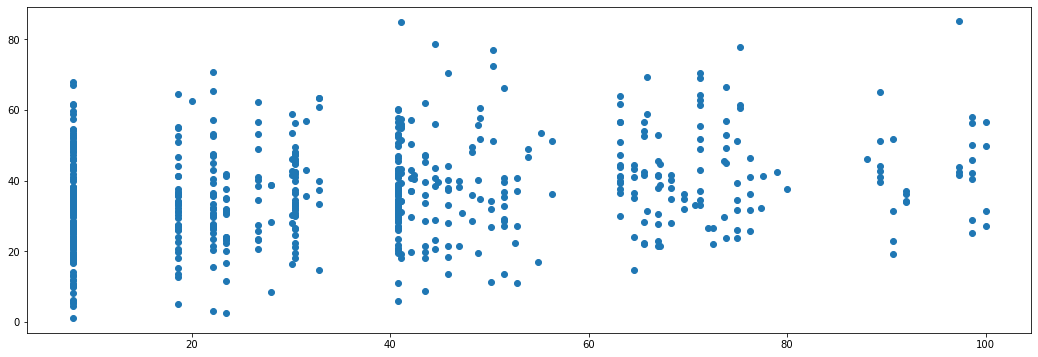

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.show();